<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/Face_recognition-Part1/Face_align.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import dlib
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
x=[]
y=[]
det=' '
OrderedDict={}
color = (255, 0, 0) 
thickness = 2

In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2020-08-14 07:09:10--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.2MB/s    in 3.4s    

2020-08-14 07:09:13 (18.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
def predict(img):
 detector = dlib.get_frontal_face_detector()
 predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
 rects = detector(img, 0)
 return rects,predictor 

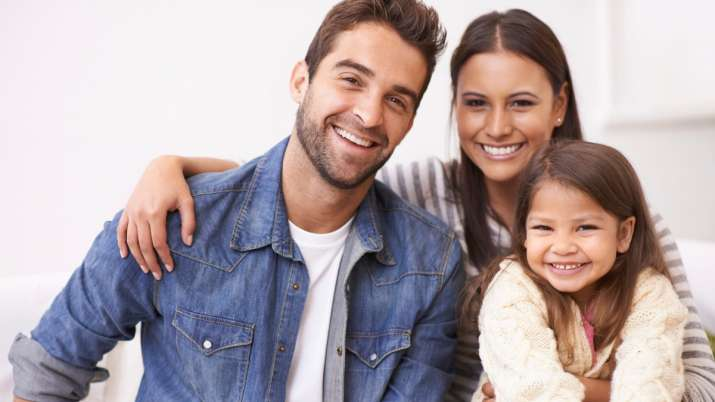

In [4]:
cv2_imshow(cv2.imread('/content/myimage.jpg'))

In [5]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	#print(coords)
	return coords

In [6]:
def individual_detection():
  FACIAL_LANDMARKS_68_IDXS = {"mouth" : (48, 68),	"inner_mouth": (60, 68),	"right_eyebrow" : (17, 22), "left_eyebrow": (22, 27), "right_eye" : (42, 48), "left_eye": (36,42) ,	"nose" : (27, 36),	"jaw" : (0, 17)
}
  return FACIAL_LANDMARKS_68_IDXS
  

In [35]:
def show_outputs(part='whole',paths='/content/myimage.jpg'):
 count=0 
 noimage= ' '
 det=part.lower()	
 img=cv2.imread(paths)
 clon=img.copy()
 rects,predictor=predict(img)
 for rect in rects:
  x = rect.left()
  y = rect.top()
  w = rect.right()-x
  h = rect.bottom()-y
  shape=predictor(img,rect)
  shape_1=shape_to_np(shape)
  
  FACIAL_LANDMARKS_68_IDXS = individual_detection()
  # Alignment function
  
  #x=tuple(x)
  #y=tuple(y)
  #
  if part=='whole':
   for (i, (x_b, y_b)) in enumerate(shape_1):
 	  	cv2.circle(img, (x_b, y_b), 1, (0, 0, 255), -1) 

  elif det == 'mouth' or det == 'inner_mouth' or det == 'right_eyebrow' or det == 'left_eyebrow' or det == 'right_eye' or det == 'left_eye' or det == 'nose' or det == 'jaw':
  
   x_p = FACIAL_LANDMARKS_68_IDXS[det][0]
   y_p = FACIAL_LANDMARKS_68_IDXS[det][1]
   for (i, (x_b, y_b)) in enumerate(shape_1):
    if i > x_p-1 and i < y_p:
     cv2.circle(img, (x_b, y_b), 1, (0, 0, 255), -1)
   #cv2_imshow(img)  
  elif det == 'filled':
     
     img=visualize_facial_landmarks(img, shape_1,FACIAL_LANDMARKS_68_IDXS)
     #cv2_imshow(img)	 
  elif det == 'align':
     count +=1
     print('getting the aligned picture:',count)
     img=align(predictor,clon,rect,FACIAL_LANDMARKS_68_IDXS,desiredLeftEye=(0.35, 0.35),desiredFaceWidth=256)
  else:
    print("check option")  
    noimage = 'No' 
    break	
 if det != 'align' or noimage == 'yes':
   noimage = 'yes' 	
   print('getting the picture......')	 
   cv2_imshow(img)		 

In [8]:
def visualize_facial_landmarks(image, shape,FACIAL_LANDMARKS_IDXS,colors=None, alpha=0.75):
	# create two copies of the input image -- one for the
	# overlay and one for the final output image
  overlay = image.copy()
  output = image.copy()

	# if the colors list is None, initialize it with a unique
	# color for each facial landmark region
  if colors is None:
    colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
			(168, 100, 168), (158, 163, 32),
			(163, 38, 32), (180, 42, 220),(180, 42, 220)]

	# loop over the facial landmark regions individually
  for (i, name) in enumerate(FACIAL_LANDMARKS_IDXS.keys()):
		# grab the (x, y)-coordinates associated with the
		# face landmark
    (j, k) = FACIAL_LANDMARKS_IDXS[name]
    pts = shape[j:k]

		# check if are supposed to draw the jawline
    if name == "jaw":
			# since the jawline is a non-enclosed facial region,
			# just draw lines between the (x, y)-coordinates
      for l in range(1, len(pts)):
        ptA = tuple(pts[l - 1])
        ptB = tuple(pts[l])
        cv2.line(overlay, ptA, ptB, colors[i], 2)

		# otherwise, compute the convex hull of the facial
		# landmark coordinates points and display it
    else:
      hull = cv2.convexHull(pts)
      cv2.drawContours(overlay, [hull], -1, colors[i], -1)

	# apply the transparent overlay
  cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

	# return the output image
  return output

In [18]:
#Face Alignment:

def align(predictor,image,rect,FACIAL_LANDMARKS_IDXS,desiredLeftEye=(0.35, 0.35),desiredFaceWidth=256, desiredFaceHeight=None):
		# store the facial landmark predictor, desired output left
		# eye position, and desired output face width + height
 predictor = predictor
 desiredLeftEye = desiredLeftEye
 desiredFaceWidth = desiredFaceWidth
 desiredFaceHeight = desiredFaceHeight

		# if the desired face height is None, set it to be the
		# desired face width (normal behavior)
 if desiredFaceHeight is None:
  desiredFaceHeight = desiredFaceWidth
 shape = predictor(image, rect)
 shape = shape_to_np(shape)
    # extract the left and right eye (x, y)-coordinates
 (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
 (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]

 leftEyePts = shape[lStart:lEnd]
 rightEyePts = shape[rStart:rEnd]

 leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
 rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

 #i=leftEyeCenter[0]
 #j=leftEyeCenter[1]
 #k=rightEyeCenter[0]
 #l=rightEyeCenter[1]

 dY = rightEyeCenter[1] - leftEyeCenter[1]
 dX = rightEyeCenter[0] - leftEyeCenter[0]
 
 #print(dY,dX)
 
 angle = np.degrees(np.arctan2(dY, dX)) 
 #img1=cv2.circle(image,(dX,dY), 1,(0, 0, 255), -7)
 

 # compute the desired right eye x-coordinate based on the
 # desired x-coordinate of the left eye
 desiredRightEyeX = 1.0 - desiredLeftEye[0]
 # determine the scale of the new resulting image by taking
 # the ratio of the distance between eyes in the *current*
 # image to the ratio of distance between eyes in the
 # *desired* image
 dist = np.sqrt((dX ** 2) + (dY ** 2))
 desiredDist = (desiredRightEyeX - desiredLeftEye[0])
 desiredDist *= desiredFaceWidth
 scale = desiredDist / dist
# compute center (x, y)-coordinates (i.e., the median point)
 # between the two eyes in the input image
 eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
             (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 #img1=cv2.circle(image,eyesCenter, 1,(0, 0, 255), -7)
 # grab the rotation matrix for rotating and scaling the face
 #print(angle)
 M = cv2.getRotationMatrix2D(eyesCenter, angle,scale)
 # update the translation component of the matrix
 tX = desiredFaceWidth * 0.5
 tY = desiredFaceHeight * desiredLeftEye[1]
 M[0, 2] += (tX - eyesCenter[0])
 M[1, 2] += (tY - eyesCenter[1])
 # apply the affine transformation
 (w, h) = (desiredFaceWidth, desiredFaceHeight)
 x1 = rect.left()
 y1 = rect.top()
 w1 = rect.right()-x1
 h1 = rect.bottom()-y1

 output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
 cv2_imshow(output)
 

 ###############Implement matplotlib code here ##############################

 ###########################################################
 return output


getting the picture......


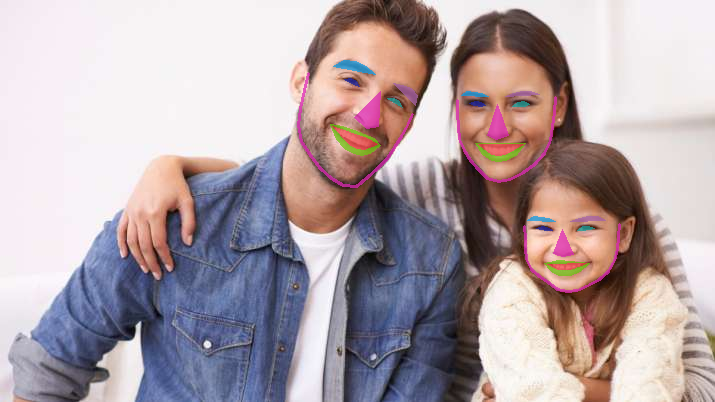

In [24]:
show_outputs(part='filled',paths='/content/myimage.jpg') 

# part can be [ align--for aligned face ,whole--red circle ,filled--coloured , nose ,right_eye,left_eye,jaw,right_eyebrow,left_eyebrow,inner_mouth,mouth] 


#Refernce                    - https://github.com/jrosebr1/imutils/tree/master/imutils/face_utils
                            # https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
                            #http://web.cse.ohio-state.edu/~shen.94/681/Site/Slides_files/transformation_review.pdf ---Basic Coordinate to understannd M

getting the picture......


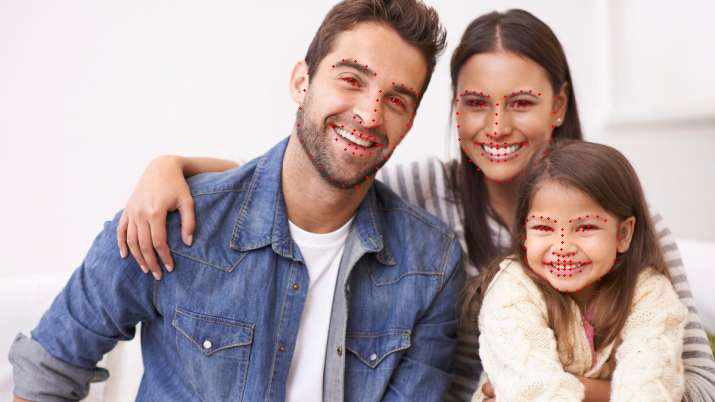

In [28]:
show_outputs(part='whole',paths='/content/myimage.jpg') 

getting the aligned picture: 1


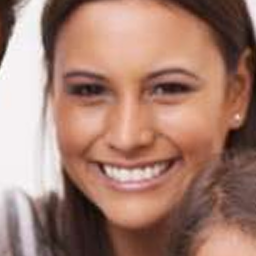

getting the aligned picture: 2


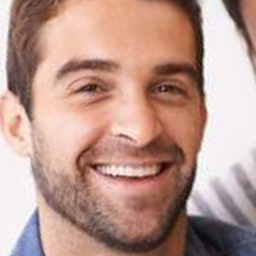

getting the aligned picture: 3


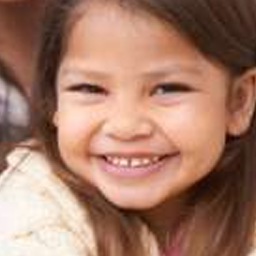

In [36]:
show_outputs(part='align',paths='/content/myimage.jpg') 

getting the picture......


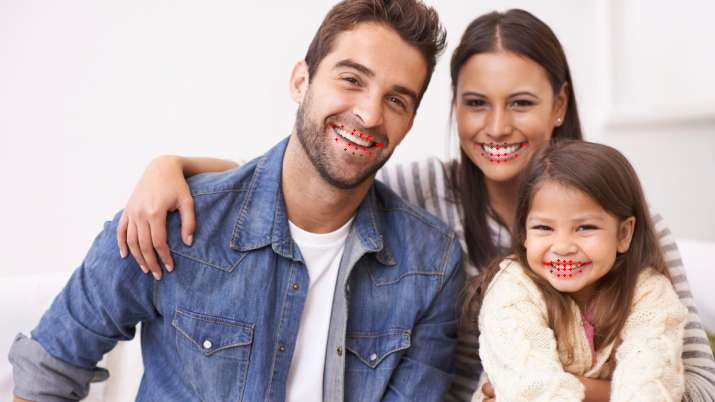

In [32]:
show_outputs(part='mouth',paths='/content/myimage.jpg') 

getting the picture......


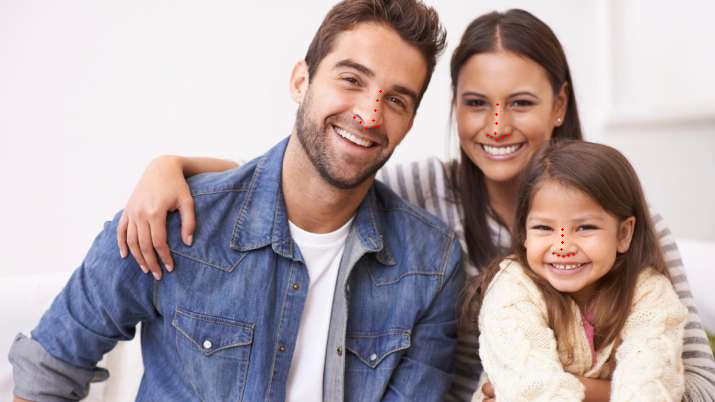

In [33]:
show_outputs(part='nose',paths='/content/myimage.jpg') 

getting the picture......


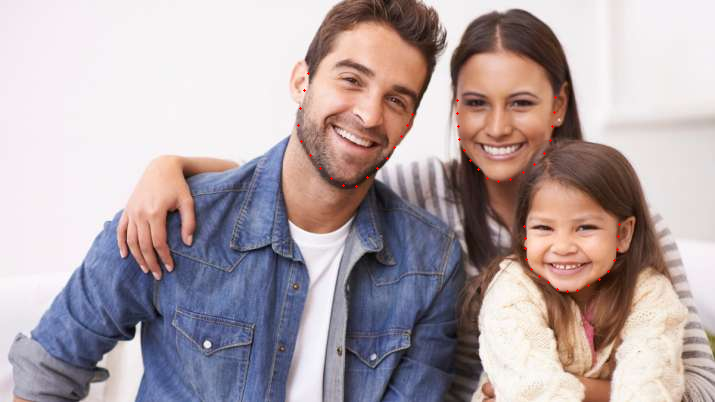

In [34]:
show_outputs(part='jaw',paths='/content/myimage.jpg') 